# NYC Main St subway ridership exploration

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
sns.__version__

'0.7.0'

## Parse data

In [5]:
subway = pd.read_csv('nyc_subway_weather.csv', parse_dates=[1, 7])

In [6]:
subway.head(2)

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,2011-05-01,00:00:00,4388333,2911002,0.0,0.0,2011-05-01 00:00:00,0,6,...,30.22,0,55.9,3.5,0.0,30.258,55.98,7.86,40.700348,-73.887177
1,R003,2011-05-01,04:00:00,4388333,2911002,0.0,0.0,2011-05-01 04:00:00,4,6,...,30.25,0,52.0,3.5,0.0,30.258,55.98,7.86,40.700348,-73.887177


The NYC subway data is quite complex, so for this tutorial let's pick one station to explore.


In [7]:
main_st = subway[subway.station == 'MAIN ST']
main_st.shape

(186, 27)

This is a big station but it only has one turnstile unit (R055). If there were more units, we would need to do additional processing to sum the `ENTRIESn_hourly` across all turnstiles for each date and time. 

In [8]:
main_st.UNIT.value_counts()

R055    186
Name: UNIT, dtype: int64

## Mean by hour - line plot

We can take a look at how ridership changes at different times of the day. A simple way to do this is to find the average ridership for a given hour.


In [9]:
# check number of records for each hour
main_st.hour.value_counts()

20    31
16    31
12    31
8     31
4     31
0     31
Name: hour, dtype: int64

In [10]:
mean_by_hour = main_st.groupby('hour')['ENTRIESn_hourly'].mean()

This produces a series, with the hour as the index:

In [11]:
mean_by_hour

hour
0      5617.645161
4       723.774194
8      8054.645161
12    15608.032258
16     9789.032258
20    10361.903226
Name: ENTRIESn_hourly, dtype: float64

The simplest way to plot it is, well, to call the built-in Series plot function.

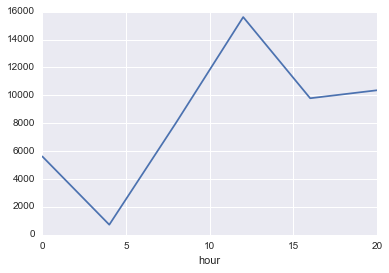

In [12]:
mean_by_hour.plot()

This line plot is reasonably effective at showing the ridership by hour. Note that the x-axis labels are not aligned with the actual data points. We can fix it as follows:

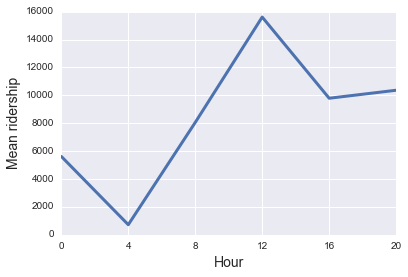

In [13]:
mean_by_hour.plot(linewidth=3)
plt.xticks(main_st.hour.unique()) # set x-axis ticks at [0, 4, 8, 12, 16, 20]
plt.ylabel('Mean ridership', fontsize=14)
plt.xlabel('Hour', fontsize=14)
plt.show()

##Deeper insights with grouped bars

To delve deeper into this relationship, we can use a bar plot - the `barplot` function from seaborn.

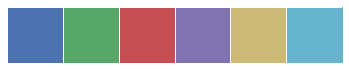

In [14]:
# take a look at the default seaborn palette
# we will use these colors for our visualizations
default_pal = sns.color_palette()
sns.palplot(default_pal)

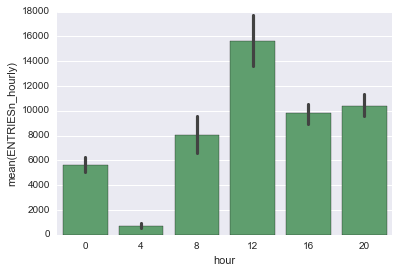

In [15]:
sns.barplot(data=main_st, x='hour', y='ENTRIESn_hourly',
            # use a fixed color from the default palette
            # otherwise, each bar will be of different color
            color=default_pal[1])
plt.show()

Note that we used the raw data (`main_st`) rather than the aggregated series (`mean_by_hour`). Seaborn automatically aggregates our 'ENTRIESn_hourly' variable for each hour. By default, the mean function is  applied to compute an aggregated result (for each hour). You can pass a different function using the `estimator` argument, such as `estimator=np.median`.

One additional advantage of using the `barplot` function is that it provides us with error-bars. It is very important to know what is the variability in our point estimates (average ridership in this case). For example, how large is the ridership difference between hour=16 and hour=20 relative to the variability in these two hours?

We can easily add an additional categorical variable (rain) using the hue argument, which creates a grouped bar chart:

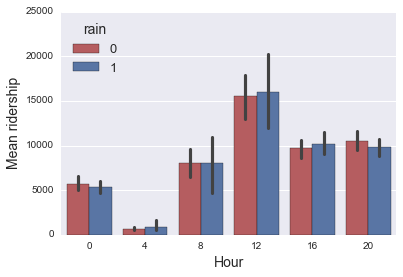

In [16]:
bar = sns.barplot(data=main_st, x='hour', y='ENTRIESn_hourly', hue='rain',
                 # OPTIONAL: use red for no-rain (0) and blue for rain (1)
                 palette={0: default_pal[2], 1: default_pal[0]})

bar.set_xlabel('Hour', fontsize=14)
bar.set_ylabel('Mean ridership', fontsize=14)

# OPTIONAL: improve on the default legend
legend = bar.legend(loc='upper left', fontsize=13, title='rain')
legend.get_title().set_fontsize(14)

We can see that the difference between rain and no-rain is quite small compared to the variability for each hour. 

We can expect ridership to be very different between weekdays and weekends causing a large variability in our estimates by hour. We might be able to dicrease this if we further segment our visualization using `factorplot`. 

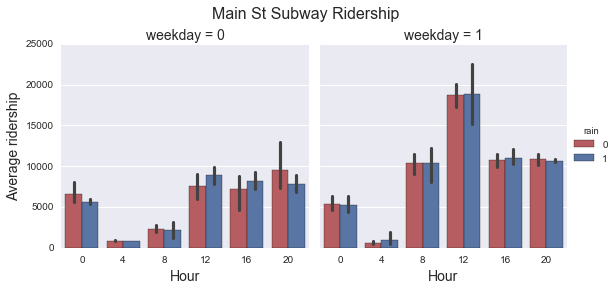

In [17]:
factors = sns.factorplot(data=main_st, x='hour', y='ENTRIESn_hourly', hue='rain', 
            col='weekday', kind='bar', 
            palette={0: default_pal[2], 1: default_pal[0]})

factors.set_xlabels('Hour', fontsize=14)
factors.set_ylabels('Average ridership', fontsize=14)
plt.suptitle('Main St Subway Ridership', fontsize=16)

# OPTIONAL: adjust title spacing and fontsize
factors.fig.subplots_adjust(top=0.85)
for ax in factors.axes[0]: ax.set_title(ax.get_title(), fontsize=14)

As we can see, there is a huge difference in ridership between weekdays and weekends for hour > 4, so it was important to separate it out. 

There does appear to be some difference in ridership between rain and no-rain during weekends (`weekday = 0`). At this point, we can't make a conclusion - a more robust statistical analysis is needed since the differences are quite small. But this type of visualizations are a great starting point.  

Another thing to keep in mind is that as we segment our data, we decrease the number of observations in each grouping. We can see, for example, that there are only two observations that correspond to a rainy weekend, at hour==20:

In [18]:
main_st.loc[(main_st.hour==20) & (main_st.weekday==0) & (main_st.rain==1)]\
    [['ENTRIESn_hourly', 'DATEn']]

,ENTRIESn_hourly,DATEn
8076,8866.0,2011-05-14
8082,6870.0,2011-05-15


There is a trade-off: as we segment our data, we can break up various conditions (weekends, hour) and possible confounding variables. But we work with less data in each group. 